# DS-GA 1011 Homework 2
## N-Gram and Neural Language Modeling

In [1]:
import os
import json
import jsonlines
import numpy as np
from collections import defaultdict

## I. N-Gram Language Modeling

#### Utilities

In [2]:
def load_wikitext(filename='wikitext2-sentencized.json'):
    if not os.path.exists(filename):
        !wget "https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json" -O $filename
    
    datasets = json.load(open(filename, 'r'))
    for name in datasets:
        datasets[name] = [x.split() for x in datasets[name]]
    vocab = list(set([t for ts in datasets['train'] for t in ts]))      
    print("Vocab size: %d" % (len(vocab)))
    return datasets, vocab

def perplexity(model, sequences):
    n_total = 0
    logp_total = 0
    for sequence in sequences:
        logp_total += model.sequence_logp(sequence)
        n_total += len(sequence) + 1  
    ppl = 2 ** (- (1.0 / n_total) * logp_total)  
    return ppl

### Additive Smoothing

In [3]:
class NGramAdditive(object):
    def __init__(self, n, delta, vsize):
        self.n = n
        self.delta = delta
        self.count = defaultdict(lambda: defaultdict(float))
        self.total = defaultdict(float)
        self.vsize = vsize
    
    def estimate(self, sequences):
        for sequence in sequences:
            padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
            for i in range(len(padded_sequence) - self.n+1):
                ngram = tuple(padded_sequence[i:i+self.n])
                prefix, word = ngram[:-1], ngram[-1]
                self.count[prefix][word] += 1
                self.total[prefix] += 1
                
    def sequence_logp(self, sequence):
        padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - self.n+1):
            ngram = tuple(padded_sequence[i:i+self.n])
            total_logp += np.log2(self.ngram_prob(ngram))
        return total_logp

    def ngram_prob(self, ngram):
        prefix = ngram[:-1]
        word = ngram[-1]
        prob = ((self.delta + self.count[prefix][word]) / 
                (self.total[prefix] + self.delta*self.vsize))
        return prob

In [4]:
datasets, vocab = load_wikitext()

delta = 0.0005
for n in [2, 3, 4]:
    lm = NGramAdditive(n=n, delta=delta, vsize=len(vocab)+1)  # +1 is for <eos>
    lm.estimate(datasets['train'])

    print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Train Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['train'])))
    print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Valid Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['valid'])))

Vocab size: 33175
Baseline (Additive smoothing, n=2, delta=0.0005)) Train Perplexity: 90.228
Baseline (Additive smoothing, n=2, delta=0.0005)) Valid Perplexity: 525.825
Baseline (Additive smoothing, n=3, delta=0.0005)) Train Perplexity: 26.768
Baseline (Additive smoothing, n=3, delta=0.0005)) Valid Perplexity: 2577.128
Baseline (Additive smoothing, n=4, delta=0.0005)) Train Perplexity: 19.947
Baseline (Additive smoothing, n=4, delta=0.0005)) Valid Perplexity: 9570.901


### I.1 Interpolation

In [5]:
class NGramInterpolation(object):
    def __init__(self, n, lam, vsize):
        self.n = n
        # each n-gram has a list of lambda
        self.lam = lam
        self.count = defaultdict(lambda: defaultdict(float))
        self.total = defaultdict(float)
        self.vsize = vsize
        self.unigram_cnt = 0
        
    def estimate(self, sequences):
        for sequence in sequences:
            padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
            for i in range(self.n):
                self.total[tuple(['<bos>']*i)] += 1       
            for i in range(len(padded_sequence)):
                unigram = tuple([padded_sequence[i]])
                if unigram != ('<bos>',):
                    self.unigram_cnt += 1
                    self.total[unigram] += 1
                if i > 0 and self.n > 1:
                    bigram = tuple([padded_sequence[i-1], padded_sequence[i]])
                    if bigram != tuple(['<bos>']*self.n):
                        self.total[bigram] += 1
                if i > 1 and self.n > 2:
                    trigram = tuple([padded_sequence[i-2], padded_sequence[i-1], padded_sequence[i]])
                    if trigram != tuple(['<bos>']*self.n):
                        self.total[trigram] += 1
                if i > 2 and self.n > 3:
                    quadgram = tuple([padded_sequence[i-3], padded_sequence[i-2], padded_sequence[i-1], padded_sequence[i]])
                    if quadgram != tuple(['<bos>']*self.n):
                        self.total[quadgram] += 1

    def sequence_logp(self, sequence):
        sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(sequence)):
            curr_seq = sequence[i:i+self.n]
            if len(curr_seq) == self.n:
                prob = self.lam[0] / self.vsize
                for curr_n in range(self.n):
                    word = tuple(curr_seq[curr_n:])
                    context = tuple(word[:-1])
                    curr_prob = self.ngram_prob(word, context)
                    prob += self.lam[self.n-curr_n]*curr_prob
                total_logp += np.log2(prob)
        return total_logp
    
    def ngram_prob(self, word, context):
        prob = 0
        if len(word) != 0 and len(context) == 0:
            prob += (self.total[word]/self.unigram_cnt)
        elif len(word)!=0 and len(context)!= 0 and self.total[context] != 0:
            prob += (self.total[word]/self.total[context])
        return prob

#### Results (showing $\lambda_0,\ldots,\lambda_n$ values):

In [6]:
datasets, vocab = load_wikitext()
for n in [2,3,4]:
    if n == 2:
        lam_list = [0.333, 0.333, 0.333]
    if n == 3:
        lam_list = [0.25, 0.25, 0.25, 0.25]
    if n == 4:
        lam_list = [0.05, 0.3, 0.6, 0.025, 0.025]
    lm = NGramInterpolation(n=n, lam=lam_list, vsize=len(vocab)+1)  # +1 is for <eos>
    lm.estimate(datasets['train'])
    print("(Interpolation smoothing, n={}, lambda={})) Train Perplexity: {}".format(n, lam_list, round(perplexity(lm, datasets['train']),4)))
    print("(Interpolation smoothing, n={}, lambda={})) Valid Perplexity: {}".format(n, lam_list, round(perplexity(lm, datasets['valid']),4)))
    

Vocab size: 33175
(Interpolation smoothing, n=2, lambda=[0.333, 0.333, 0.333])) Train Perplexity: 179.2331
(Interpolation smoothing, n=2, lambda=[0.333, 0.333, 0.333])) Valid Perplexity: 395.9987
(Interpolation smoothing, n=3, lambda=[0.25, 0.25, 0.25, 0.25])) Train Perplexity: 23.5523
(Interpolation smoothing, n=3, lambda=[0.25, 0.25, 0.25, 0.25])) Valid Perplexity: 329.4738
(Interpolation smoothing, n=4, lambda=[0.05, 0.3, 0.6, 0.025, 0.025])) Train Perplexity: 24.1527
(Interpolation smoothing, n=4, lambda=[0.05, 0.3, 0.6, 0.025, 0.025])) Valid Perplexity: 284.6594


As the shown in the results above:
1. All three interpolation models outperform the additive smoothing model.
2. Performance improves as a function of n.


In [7]:
# Check: lower order model is a special case of a higher order model. 
# For instance, a 2-gram interpolation model is a 3-gram interpolation model with λ3 = 0.
datasets, vocab = load_wikitext()
for n in [2, 3, 4]:
    #lam_list = [1/(n+1)]*(n+1)
    if n == 2:
        lam_list = [0.333, 0.333, 0.333]
    if n == 3:
        lam_list = [0.333, 0.333, 0.333, 0]
    if n == 4:
        lam_list = [0.333, 0.333, 0.333, 0, 0]
    lm = NGramInterpolation(n=n, lam=lam_list, vsize=len(vocab)+1)  # +1 is for <eos>
    lm.estimate(datasets['train'])
    print("(Interpolation smoothing, n={}, lambda={})) Train Perplexity: {}".format(n, lam_list, round(perplexity(lm, datasets['train']),4)))
    print("(Interpolation smoothing, n={}, lambda={})) Valid Perplexity: {}".format(n, lam_list, round(perplexity(lm, datasets['valid']),4)))

Vocab size: 33175
(Interpolation smoothing, n=2, lambda=[0.333, 0.333, 0.333])) Train Perplexity: 179.2331
(Interpolation smoothing, n=2, lambda=[0.333, 0.333, 0.333])) Valid Perplexity: 395.9987
(Interpolation smoothing, n=3, lambda=[0.333, 0.333, 0.333, 0])) Train Perplexity: 179.2331
(Interpolation smoothing, n=3, lambda=[0.333, 0.333, 0.333, 0])) Valid Perplexity: 395.9987
(Interpolation smoothing, n=4, lambda=[0.333, 0.333, 0.333, 0, 0])) Train Perplexity: 179.2331
(Interpolation smoothing, n=4, lambda=[0.333, 0.333, 0.333, 0, 0])) Valid Perplexity: 395.9987


## II. Neural Language Modeling with a Recurrent Neural Network

In [5]:
import torch
import torch.nn as nn

#### Utilities

(Hint: you can adopt the `Dictionary`, dataset loading, and training code from the lab for use here)

### Define Dictionary class and build dictionary

In [6]:
import sys
import os
from tqdm import tqdm
import jsonlines
class Dictionary(object):
    def __init__(self, datasets, include_valid=False):
        self.tokens = []
        self.ids = {}
        self.counts = {}
        
        # add special tokens
        self.add_token('<bos>')
        self.add_token('<eos>')
        self.add_token('<pad>')
        self.add_token('<unk>')
        
        for line in tqdm(datasets['train']):
            for w in line:
                self.add_token(w)
                    
        if include_valid is True:
            for line in tqdm(datasets['valid']):
                for w in line:
                    self.add_token(w)
                            
    def add_token(self, w):
        if w not in self.tokens:
            self.tokens.append(w)
            _w_id = len(self.tokens) - 1
            self.ids[w] = _w_id
            self.counts[w] = 1
        else:
            self.counts[w] += 1

    def get_id(self, w):
        return self.ids[w]
    
    def get_token(self, idx):
        return self.tokens[idx]
    
    def decode_idx_seq(self, l):
        return [self.tokens[i] for i in l]
    
    def encode_token_seq(self, l):
        return [self.ids[i] if i in self.ids else self.ids['<unk>'] for i in l]
    
    def __len__(self):
        return len(self.tokens)
    
def tokenize_dataset(datasets, dictionary, ngram_order=2):
    tokenized_datasets = {}
    for split, dataset in datasets.items():
        _current_dictified = []
        for l in tqdm(dataset):
            l = ['<bos>']*(ngram_order-1) + l + ['<eos>']
            encoded_l = dictionary.encode_token_seq(l)
            _current_dictified.append(encoded_l)
        tokenized_datasets[split] = _current_dictified
        
    return tokenized_datasets

def slice_sequences_given_order(tokenized_dataset_with_spec, ngram_order=5):
    sliced_datasets = {}
    for split, dataset in tokenized_dataset_with_spec.items():
        _list_of_sliced_ngrams = []
        for seq in tqdm(dataset):
            ngrams = [seq[i:i+ngram_order] for i in range(len(seq)-ngram_order+1)]
            _list_of_sliced_ngrams.extend(ngrams)
        sliced_datasets[split] = _list_of_sliced_ngrams

    return sliced_datasets

from torch.utils.data import Dataset, DataLoader
import torch

# Now we create a dataset
class NgramDataset(Dataset):
    def __init__(self, sliced_dataset_split):
        super().__init__()

        # for each sample: [:-1] is input, [-1] is target
        self.sequences = [torch.tensor(i, dtype=torch.long) for i in sliced_dataset_split]
    
    def __getitem__(self, i):
        sample = self.sequences[i]
        return sample

    def __len__(self):
        return len(self.sequences)

def batchify(list_minibatch):
    inp_list = [i[:-1] for i in list_minibatch]
    tar_list = [i[-1] for i in list_minibatch]

    inp_tensor = torch.stack(inp_list, dim=0)
    tar_tensor = torch.stack(tar_list, dim=0)

    return inp_tensor, tar_tensor

In [7]:
wiki_dict = Dictionary(datasets, include_valid=True)

100%|██████████| 8464/8464 [00:06<00:00, 1222.40it/s]


### Build tokenized data sets, dataloaders, etc.

In [8]:
import torch
from torch.utils.data import Dataset, RandomSampler, SequentialSampler, DataLoader

class TensoredDataset(Dataset):
    def __init__(self, list_of_lists_of_tokens):
        self.input_tensors = []
        self.target_tensors = []
        
        for sample in list_of_lists_of_tokens:
            self.input_tensors.append(torch.tensor([sample[:-1]], dtype=torch.long))
            self.target_tensors.append(torch.tensor([sample[1:]], dtype=torch.long))
    
    def __len__(self):
        return len(self.input_tensors)
    
    def __getitem__(self, idx):
        # return a (input, target) tuple
        return (self.input_tensors[idx], self.target_tensors[idx])

In [9]:
def pad_list_of_tensors(list_of_tensors, pad_token):
    max_length = max([t.size(-1) for t in list_of_tensors])
    padded_list = []
    
    for t in list_of_tensors:
        padded_tensor = torch.cat([t, torch.tensor([[pad_token]*(max_length - t.size(-1))], dtype=torch.long)], dim = -1)
        padded_list.append(padded_tensor)
        
    padded_tensor = torch.cat(padded_list, dim=0)
    
    return padded_tensor

def pad_collate_fn(batch):
    # batch is a list of sample tuples
    input_list = [s[0] for s in batch]
    target_list = [s[1] for s in batch]
    
    #pad_token = persona_dict.get_id('<pad>')
    pad_token = 2
    
    input_tensor = pad_list_of_tensors(input_list, pad_token)
    target_tensor = pad_list_of_tensors(target_list, pad_token)
    
    return input_tensor, target_tensor

In [10]:
wiki_tokenized_datasets = tokenize_dataset(datasets, wiki_dict)
wiki_tensor_dataset = {}

for split, listoflists in wiki_tokenized_datasets.items():
    wiki_tensor_dataset[split] = TensoredDataset(listoflists)
    
# check the first example
wiki_tensor_dataset['train'][0]

100%|██████████| 9708/9708 [00:00<00:00, 221226.59it/s]


(tensor([[ 0,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  4, 15, 16, 17, 18, 10,
          19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]]),
 tensor([[ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  4, 15, 16, 17, 18, 10, 19,
          20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,  1]]))

In [11]:
wiki_loaders = {}

batch_size = 32

for split, datasets in wiki_tensor_dataset.items():
    wiki_loaders[split] = DataLoader(datasets, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn)

### Baseline

In [12]:
import torch.nn as nn

class RNNLanguageModel(nn.Module):
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.rnn = nn.RNN(options['input_size'], options['hidden_size'], options['num_layers'], dropout=options['rnn_dropout'], batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence)
        rnn_outputs = self.rnn(embeddings)
        logits = self.projection(rnn_outputs[0])
        
        return logits

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

# creating a model, criterion and optimizer

load_pretrained = False

num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

if load_pretrained:
    if not os.path.exists('personachat_rnn_lm.pt'):
        raise EOFError('Download pretrained model!')
    model_dict = torch.load('personachat_rnn_lm.pt')
    
    options = model_dict['options']
    model = RNNLanguageModel(options).to(current_device)
    model.load_state_dict(model_dict['model_dict'])
    
else:
    embedding_size = 64
    hidden_size = 128
    num_layers = 2
    rnn_dropout = 0.1

    options = {
        'num_embeddings': len(wiki_dict),
        'embedding_dim': embedding_size,
        'padding_idx': wiki_dict.get_id('<pad>'),
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'rnn_dropout': rnn_dropout,
    }

    model = RNNLanguageModel(options).to(current_device)

# change the reduce here:
criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'), reduction='sum')

model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(model_parameters, lr=0.001)

In [14]:
options

{'num_embeddings': 33181,
 'embedding_dim': 64,
 'padding_idx': 2,
 'input_size': 64,
 'hidden_size': 128,
 'num_layers': 2,
 'rnn_dropout': 0.1}

In [15]:
# now we make same training loop, now with dataset and the model

plot_cache = []

num_epoch = 10
for epoch_number in range(num_epoch):
    avg_loss=0
    if not load_pretrained:
        # do train
        model.train()
        
        #train_log_cache = []
        
        train_loss_cache = 0
        train_non_pad_tokens_cache = 0 # take nots on non_padding tokens
        
        for i, (inp, target) in enumerate(wiki_loaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)
            
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            train_loss_cache += loss.item()
            
            ### HERE WE COMPUTE NUMBER OF NON_PAD TOKENS IN THE TARGET
            non_pad_tokens = target.view(-1).ne(wiki_dict.get_id('<pad>')).sum().item()
            train_non_pad_tokens_cache += non_pad_tokens
            loss /= non_pad_tokens  # very important to normalize your current loss before you run
            
            loss.backward()
            optimizer.step()
            
            #train_log_cache.append(loss.item())
            
            if i % 1000 == 0:
                avg_loss = train_loss_cache/train_non_pad_tokens_cache
                #train_log_cache = []
            
    #do valid
    valid_loss_cache = 0
    valid_non_pad_tokens_cache = 0
    
    #valid_losses = []
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(wiki_loaders['valid']):
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_loss_cache += loss.item()
            
            ### HERE WE COMPUTE NUMBER OF NON_PAD TOKENS IN THE TARGET
            non_pad_tokens = target.view(-1).ne(wiki_dict.get_id('<pad>')).sum().item()
            valid_non_pad_tokens_cache += non_pad_tokens
            
            #valid_losses.append(loss.item())
            
        avg_val_loss = valid_loss_cache / valid_non_pad_tokens_cache
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        
    plot_cache.append((avg_loss, avg_val_loss))

    if load_pretrained:
        break

Validation loss after 0 epoch = 5.6921
Validation loss after 1 epoch = 5.5299
Validation loss after 2 epoch = 5.4367
Validation loss after 3 epoch = 5.3889
Validation loss after 4 epoch = 5.3764
Validation loss after 5 epoch = 5.3582
Validation loss after 6 epoch = 5.3429
Validation loss after 7 epoch = 5.3389
Validation loss after 8 epoch = 5.3465
Validation loss after 9 epoch = 5.3438


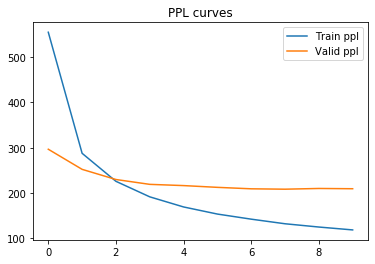

In [18]:
import matplotlib.pyplot as plt
import numpy

epochs = numpy.array(list(range(len(plot_cache))))
plt.plot(epochs, [2**(i[0]/numpy.log(2)) for i in plot_cache], label='Train ppl')
plt.plot(epochs, [2**(i[1]/numpy.log(2)) for i in plot_cache], label='Valid ppl')

plt.legend()
plt.title('PPL curves')
plt.show()

In [19]:
print('The validation perplexity after {} epochs is: {}.'.format(num_epoch, [2**(i[1]/numpy.log(2)) for i in plot_cache][-1]))

The validation perplexity after 10 epochs is: 209.29732803545787.


### II.1 LSTM and Hyper-Parameters

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim

class LSTMLanguageModel(nn.Module):
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.lstm = nn.LSTM(options['input_size'], options['hidden_size'],options['num_layers'],dropout=options['rnn_dropout'], batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence)
        lstm_outputs = self.lstm(embeddings)
        logits = self.projection(lstm_outputs[0])
        
        return logits

In [22]:
def LSTMpipeline(options):
  
  model = LSTMLanguageModel(options).to(current_device)
  criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'), reduction='sum')
  model_parameters = [p for p in model.parameters() if p.requires_grad]
  optimizer = optim.Adam(model_parameters, lr=options['learning_rate'])
  
  plot_cache = []

  num_epoch = options['num_epochs']
  for epoch_number in range(num_epoch):
      avg_loss=0
      if not load_pretrained:
        # do train
        model.train()        
        train_loss_cache = 0
        train_non_pad_tokens_cache = 0 # take nots on non_padding tokens
        
        for i, (inp, target) in enumerate(wiki_loaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)
            
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            train_loss_cache += loss.item()
            
            ### HERE WE COMPUTE NUMBER OF NON_PAD TOKENS IN THE TARGET
            non_pad_tokens = target.view(-1).ne(wiki_dict.get_id('<pad>')).sum().item()
            train_non_pad_tokens_cache += non_pad_tokens
            loss /= non_pad_tokens  # very important to normalize your current loss before you run
            
            loss.backward()
            optimizer.step()
            
            #train_log_cache.append(loss.item())
            
            if i % 100 == 0:
                avg_loss = train_loss_cache/train_non_pad_tokens_cache

                
     #do valid
      valid_loss_cache = 0
      valid_non_pad_tokens_cache = 0
 
      #valid_losses = []
      model.eval()
      with torch.no_grad():
          for i, (inp, target) in enumerate(wiki_loaders['valid']):
              inp = inp.to(current_device)
              target = target.to(current_device)
              logits = model(inp)

              loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
              valid_loss_cache += loss.item()

              ### HERE WE COMPUTE NUMBER OF NON_PAD TOKENS IN THE TARGET
              non_pad_tokens = target.view(-1).ne(wiki_dict.get_id('<pad>')).sum().item()
              valid_non_pad_tokens_cache += non_pad_tokens

              #valid_losses.append(loss.item())

          avg_val_loss = valid_loss_cache / valid_non_pad_tokens_cache
          print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        
      plot_cache.append((avg_loss, avg_val_loss))

  train_ppt = [2**(i[0]/numpy.log(2)) for i in plot_cache]
  val_ppt = [2**(i[1]/numpy.log(2)) for i in plot_cache]
  
  print('After {} eopchs, the LSTM model with paratemeters hidden dimension = {} and number of layers = {} has:\nA validation loss of {}\nA training loss of {}\nA training perplexity of {}\nA validation perplexity of {}.'\
        .format(options['num_epochs'], options['hidden_size'],options['num_layers'],plot_cache[-1][0], plot_cache[-1][1], train_ppt[-1], val_ppt[-1], prec=4))
  
  if options['save_model'] == 1:
        torch.save({
            'options': options,
            'loss_cache': plot_cache,
            'model_dict': model.state_dict()
        }, './bestlstm.pt')
    
  return plot_cache, train_ppt, val_ppt

In [23]:
def plot_LSTM(plot_cache, train_ppt, val_ppt, cnt):
  x_axis = range(len(train_ppt))
  plt.figure(figsize=(12,4))
  plt.subplot(121)
  ax1 = plt.subplot(121)
  ax1.plot(x_axis, [i[0] for i in plot_cache], label = 'train loss', alpha = 0.5)
  ax1.plot(x_axis, [i[1] for i in plot_cache], label = 'val loss', alpha = 0.5)
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.legend()
  ax2 = plt.subplot(122)
  ax2.plot(x_axis, train_ppt, label = 'train perplexity', alpha = 0.5)
  ax2.plot(x_axis, val_ppt, label = 'val perplexity', alpha = 0.5)
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Perplexity')
  ax2.legend()
  plt.show()
  plt.savefig('lstm_{}.png'.format(cnt))
  plt.clf()

#### Results (LSTM vs. Baseline)

In [30]:
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

options = {
  'embedding_dim': 512,
  'hidden_size': 512,
  'input_size': 512,
  'num_embeddings': 33181,
  'num_layers': 2,
  'padding_idx': 2,
  'rnn_dropout': 0.1,
  'num_epochs': 3,
  'learning_rate': 0.001,
  'save_model': 1}
  
plot_cache, train_ppt, val_ppt = LSTMpipeline(options)

Validation loss after 0 epoch = 5.3677
Validation loss after 1 epoch = 5.1217
Validation loss after 2 epoch = 5.0650
After 3 eopchs, the LSTM model with paratemeters hidden dimension = 512 and number of layers = 2 has:
A validation loss of 4.7127240458640784
A training loss of 5.06503920503024
A training perplexity of 111.35508348412927
A validation perplexity of 158.3866515054223.


In [34]:
print('The validation perplexity for best LSTM model is: {}.'.format(val_ppt[-1]))

The validation perplexity for best LSTM model is: 158.3866515054223.


#### Performance Variation Based on Hyperparameter Values

#### tune num_layers

D:\Software\Anaconda\lib\site-packages\torch\nn\modules\rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Validation loss after 0 epoch = 5.2245
Validation loss after 1 epoch = 5.0811
Validation loss after 2 epoch = 5.1112
Validation loss after 3 epoch = 5.1972
Validation loss after 4 epoch = 5.3060
After 5 eopchs, the LSTM model with paratemeters hidden dimension = 512 and number of layers = 1 has:
A validation loss of 3.5274324921125384
A training loss of 5.305980611606572
A training perplexity of 34.03646643680229
A validation perplexity of 201.5385365738581.


D:\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


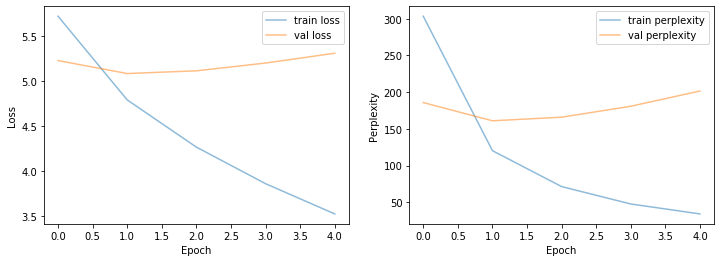

Validation loss after 0 epoch = 5.4058
Validation loss after 1 epoch = 5.1407
Validation loss after 2 epoch = 5.0695
Validation loss after 3 epoch = 5.0983
Validation loss after 4 epoch = 5.1781
After 5 eopchs, the LSTM model with paratemeters hidden dimension = 512 and number of layers = 2 has:
A validation loss of 4.1293911208340655
A training loss of 5.178110274514587
A training perplexity of 62.14007561629589
A validation perplexity of 177.34735631556498.


<Figure size 432x288 with 0 Axes>

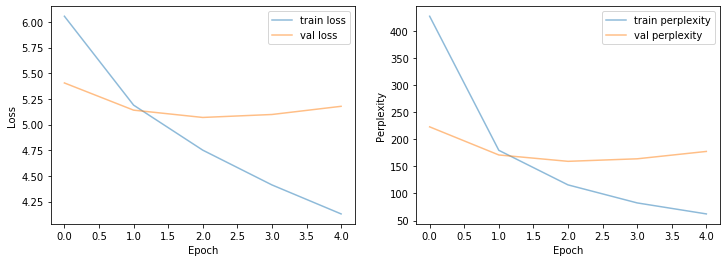

Validation loss after 0 epoch = 5.6331
Validation loss after 1 epoch = 5.3292
Validation loss after 2 epoch = 5.2088
Validation loss after 3 epoch = 5.1678
Validation loss after 4 epoch = 5.2049
After 5 eopchs, the LSTM model with paratemeters hidden dimension = 512 and number of layers = 3 has:
A validation loss of 4.532280701672646
A training loss of 5.204867460985298
A training perplexity of 92.97035711750357
A validation perplexity of 182.15672829548416.


<Figure size 432x288 with 0 Axes>

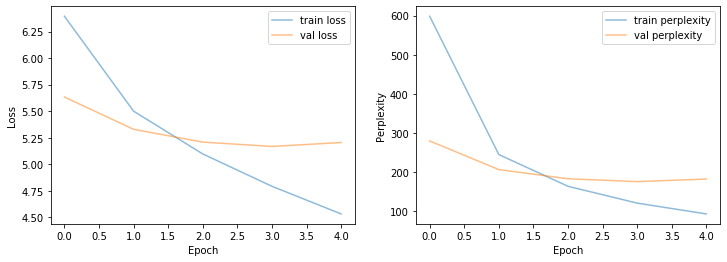

Validation loss after 0 epoch = 5.7509
Validation loss after 1 epoch = 5.3600
Validation loss after 2 epoch = 5.2162
Validation loss after 3 epoch = 5.1892
Validation loss after 4 epoch = 5.2182
After 5 eopchs, the LSTM model with paratemeters hidden dimension = 512 and number of layers = 4 has:
A validation loss of 4.581042459377004
A training loss of 5.218249561688316
A training perplexity of 97.61610200560155
A validation perplexity of 184.61075134684577.


<Figure size 432x288 with 0 Axes>

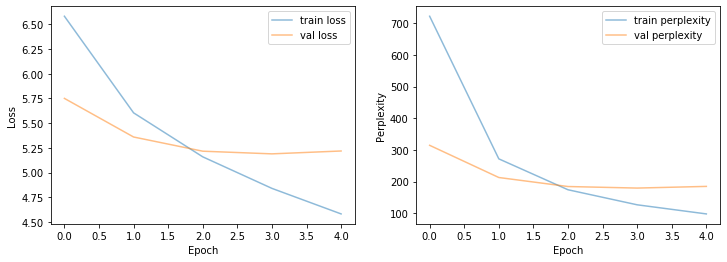

D:\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


<Figure size 432x288 with 0 Axes>

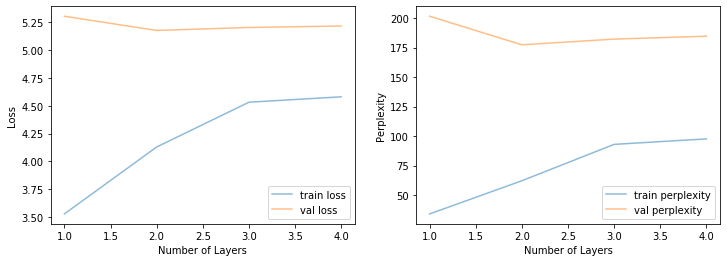

<Figure size 432x288 with 0 Axes>

In [24]:
results = {'train_loss':[], 'val_loss':[], 'train_ppt':[], 'val_ppt':[]}
cnt = 0

for hidden in [1,2,3,4]:
  
  options = {
      'embedding_dim': 512,
      'hidden_size': 512,
      'input_size': 512,
      'num_embeddings': 33181,
      'num_layers': hidden,
      'padding_idx': 2,
      'rnn_dropout': 0.1,
      'num_epochs': 5,
      'learning_rate': 0.001,
      'save_model': 1}
  
  plot_cache, train_ppt, val_ppt = LSTMpipeline(options)
  results['train_loss'].append(plot_cache[-1][0])
  results['val_loss'].append(plot_cache[-1][1])
  results['train_ppt'].append(train_ppt[-1])
  results['val_ppt'].append(val_ppt[-1])
  
  plot_LSTM(plot_cache, train_ppt, val_ppt, cnt)
  
  cnt += 1
    
x_axis = [1,2,3,4]
plt.figure(figsize=(12,4))
plt.subplot(121)
ax1 = plt.subplot(121)
ax1.plot(x_axis, results['train_loss'], label = 'train loss', alpha = 0.5)
ax1.plot(x_axis, results['val_loss'], label = 'val loss', alpha = 0.5)
ax1.set_xlabel('Number of Layers')
ax1.set_ylabel('Loss')
ax1.legend()
ax2 = plt.subplot(122)
ax2.plot(x_axis, results['train_ppt'], label = 'train perplexity', alpha = 0.5)
ax2.plot(x_axis, results['val_ppt'], label = 'val perplexity', alpha = 0.5)
ax2.set_xlabel('Number of Layers')
ax2.set_ylabel('Perplexity')
ax2.legend()
plt.show()
plt.savefig('figure_layer.png')
plt.clf()

#### tune embed_dim

Validation loss after 0 epoch = 5.5975
Validation loss after 1 epoch = 5.3076
Validation loss after 2 epoch = 5.2053
Validation loss after 3 epoch = 5.1852
Validation loss after 4 epoch = 5.2279
After 5 eopchs, the LSTM model with paratemeters hidden dimension = 512 and number of layers = 2 has:
A validation loss of 4.461810634980324
A training loss of 5.227895845206055
A training perplexity of 86.64424826154688
A validation perplexity of 186.40017576681362.


D:\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


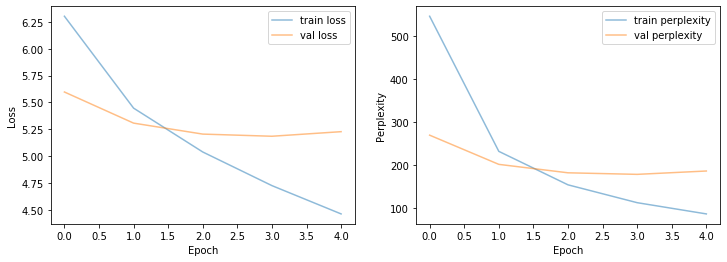

Validation loss after 0 epoch = 5.4901
Validation loss after 1 epoch = 5.2194
Validation loss after 2 epoch = 5.1314
Validation loss after 3 epoch = 5.1434
Validation loss after 4 epoch = 5.2004
After 5 eopchs, the LSTM model with paratemeters hidden dimension = 512 and number of layers = 2 has:
A validation loss of 4.311984240831762
A training loss of 5.200395584884408
A training perplexity of 74.58834343899274
A validation perplexity of 181.34396461928114.


<Figure size 432x288 with 0 Axes>

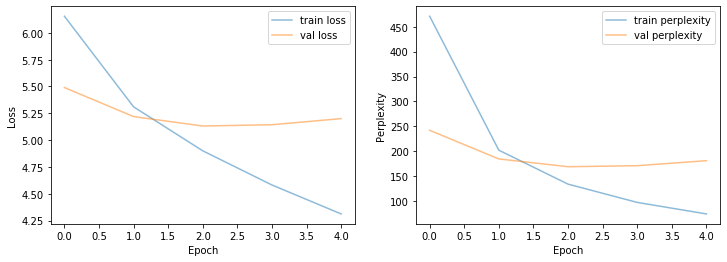

Validation loss after 0 epoch = 5.4087
Validation loss after 1 epoch = 5.1471
Validation loss after 2 epoch = 5.0623
Validation loss after 3 epoch = 5.0930
Validation loss after 4 epoch = 5.1721
After 5 eopchs, the LSTM model with paratemeters hidden dimension = 512 and number of layers = 2 has:
A validation loss of 4.128662348531441
A training loss of 5.1720707559274155
A training perplexity of 62.0948061478747
A validation perplexity of 176.2794916010389.


<Figure size 432x288 with 0 Axes>

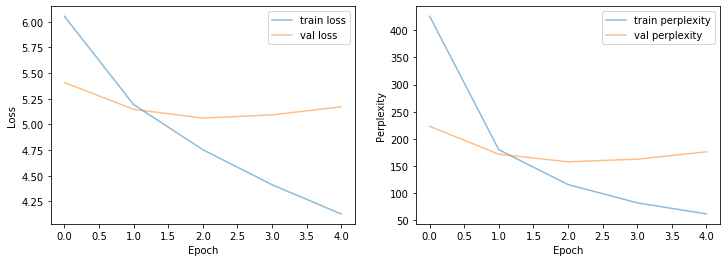

D:\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


<Figure size 432x288 with 0 Axes>

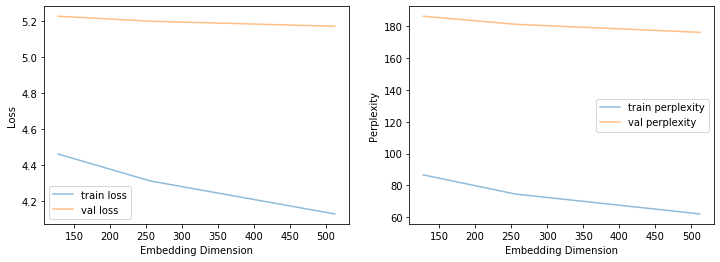

<Figure size 432x288 with 0 Axes>

In [25]:
results = {'train_loss':[], 'val_loss':[], 'train_ppt':[], 'val_ppt':[]}
cnt = 0

for emb_dim in [128, 256, 512]:
  
  options = {
      'embedding_dim': emb_dim,
      'hidden_size': 512,
      'input_size': emb_dim,
      'num_embeddings': 33181,
      'num_layers': 2,
      'padding_idx': 2,
      'rnn_dropout': 0.1,
      'num_epochs': 5,
      'learning_rate': 0.001,
      'save_model': 1}
  
  plot_cache, train_ppt, val_ppt = LSTMpipeline(options)
  results['train_loss'].append(plot_cache[-1][0])
  results['val_loss'].append(plot_cache[-1][1])
  results['train_ppt'].append(train_ppt[-1])
  results['val_ppt'].append(val_ppt[-1])
  
  plot_LSTM(plot_cache, train_ppt, val_ppt, cnt)
  
  cnt += 1

x_axis = [128,256,512]
plt.figure(figsize=(12,4))
plt.subplot(121)
ax1 = plt.subplot(121)
ax1.plot(x_axis, results['train_loss'], label = 'train loss', alpha = 0.5)
ax1.plot(x_axis, results['val_loss'], label = 'val loss', alpha = 0.5)
ax1.set_xlabel('Embedding Dimension')
ax1.set_ylabel('Loss')
ax1.legend()
ax2 = plt.subplot(122)
ax2.plot(x_axis, results['train_ppt'], label = 'train perplexity', alpha = 0.5)
ax2.plot(x_axis, results['val_ppt'], label = 'val perplexity', alpha = 0.5)
ax2.set_xlabel('Embedding Dimension')
ax2.set_ylabel('Perplexity')
ax2.legend()
plt.show()
plt.savefig('figure_emb_dim.png')
plt.clf()

As we can see in the plots, the validation perplexity keeps going down as the Embedding Dimension goes up, so we picked the largest emb_dim = 512. After we set the emb_dim constant, the validation perplexity reaches its lowest when number of layer=2. When number of epoch> 3 it overfits so we chose num_epoch = 3. We saved the best model and compared the results with baseline model.

### II.2 Learned Embeddings

#### Utilities

Below is code to use [UMAP](https://umap-learn.readthedocs.io/en/latest/) to find a 2-dimensional representation of a weight matrix, and plot the resulting 2-dimensional points that correspond to certain words.

Use `!pip install umap-learn` to install UMAP.

In [32]:
%pylab inline 
import umap
import matplotlib.pyplot as plt

def umap_plot(weight_matrix, word_ids, words):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix.detach().cpu().numpy())
    facecolor = ['r','y','g','k','b','r','y','g','k','b']
    plt.figure(figsize=(20,20))

    to_plot = reduced[word_ids, :]
    for i, word_id in enumerate(word_ids):
        if i // 50 == 0:
            plt.scatter(to_plot[i, 0], to_plot[i, 1], c =facecolor[i//10])
        else:
            plt.scatter(to_plot[i, 0], to_plot[i, 1], c =facecolor[i//10], alpha = 0.3)
        current_point = to_plot[i]
        plt.annotate(words[i], (current_point[0], current_point[1]))
        
    plt.grid()
    plt.show()

Populating the interactive namespace from numpy and matplotlib


D:\Software\Anaconda\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['split']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [27]:
#load best model
model_dict = torch.load('bestlstm.pt')
options = model_dict['options']
model = LSTMLanguageModel(options).to(current_device)
model.load_state_dict(model_dict['model_dict'])

<All keys matched successfully>

#### II.2.1 Word Similarity

In [35]:
sample = ['government', 'where', '1995', 'search', 'German']
import operator

closest = {}
furthest = {}

for word in sample:
  sample_to_vec = model.lookup.weight[wiki_dict.get_id(word)]
  emb_word_sim = {}
  for each in vocab:
    each_to_vec = model.lookup.weight[wiki_dict.get_id(each)]
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    output = cos(each_to_vec.unsqueeze(0),sample_to_vec.unsqueeze(0)).item()
    emb_word_sim[each]=output
    
  sorted_dic = sorted(emb_word_sim.items(), key=operator.itemgetter(1))
  closest[word] = sorted_dic[-10:]
  furthest[word] = sorted_dic[:10]

In [46]:
for i in closest:
    temp_output = []
    for j in range(10):
        temp_output.append(closest[i][j][0])
    print("10 'closet' words of", i, "are", temp_output)
for i in furthest:
    temp_output = []
    for j in range(10):
        temp_output.append(furthest[i][j][0])
    print("10 'furthest' words of", i, "are", temp_output)

10 'closet' words of government are ['parrots', 'cephalothorax', 'torpedoes', 'memories', 'MGB', 'Connor', 'grandfather', 'Mile', '1660', 'government']
10 'closet' words of where are ['Cassandra', 'Update', 'Priest', 'worth', 'explore', 'contrasted', 'Zzap', 'transcription', 'Moravec', 'where']
10 'closet' words of 1995 are ['bottle', 'Disappeared', 'Hampstead', 'Fortress', 'Oxford', 'Y', 'landings', 'shrine', 'Hampshires', '1995']
10 'closet' words of search are ['pensioners', 'coordination', 'civilizations', 'Bassline', 'seamlessly', 'move', 'sequences', 'valens', 'hospitalization', 'search']
10 'closet' words of German are ['hardline', 'Saratoga', 'Dubrava', 'Harishchandra', 'fragrance', 'adjoining', 'oldest', 'RML', 'Karamokho', 'German']
10 'furthest' words of government are ['serpent', 'Squirtle', 'beset', 'accented', 'wheels', 'robotics', 'living', 'Nerys', 'organization', 'comb']
10 'furthest' words of where are ['park', 'MVPs', 'Bridgwater', 'Kendrick', 'Creighton', '406', 'co

#### II.2.2 Embedding Layer

D:\Software\Anaconda\lib\site-packages\numba\compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\..\..\Software\Anaconda\lib\site-packages\umap\rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
D:\Software\Anaconda\lib\site-packages\numba\compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\..\..\Software\Anaconda\lib\site-packages\umap\rp_tree.py", line 135:
@numba.

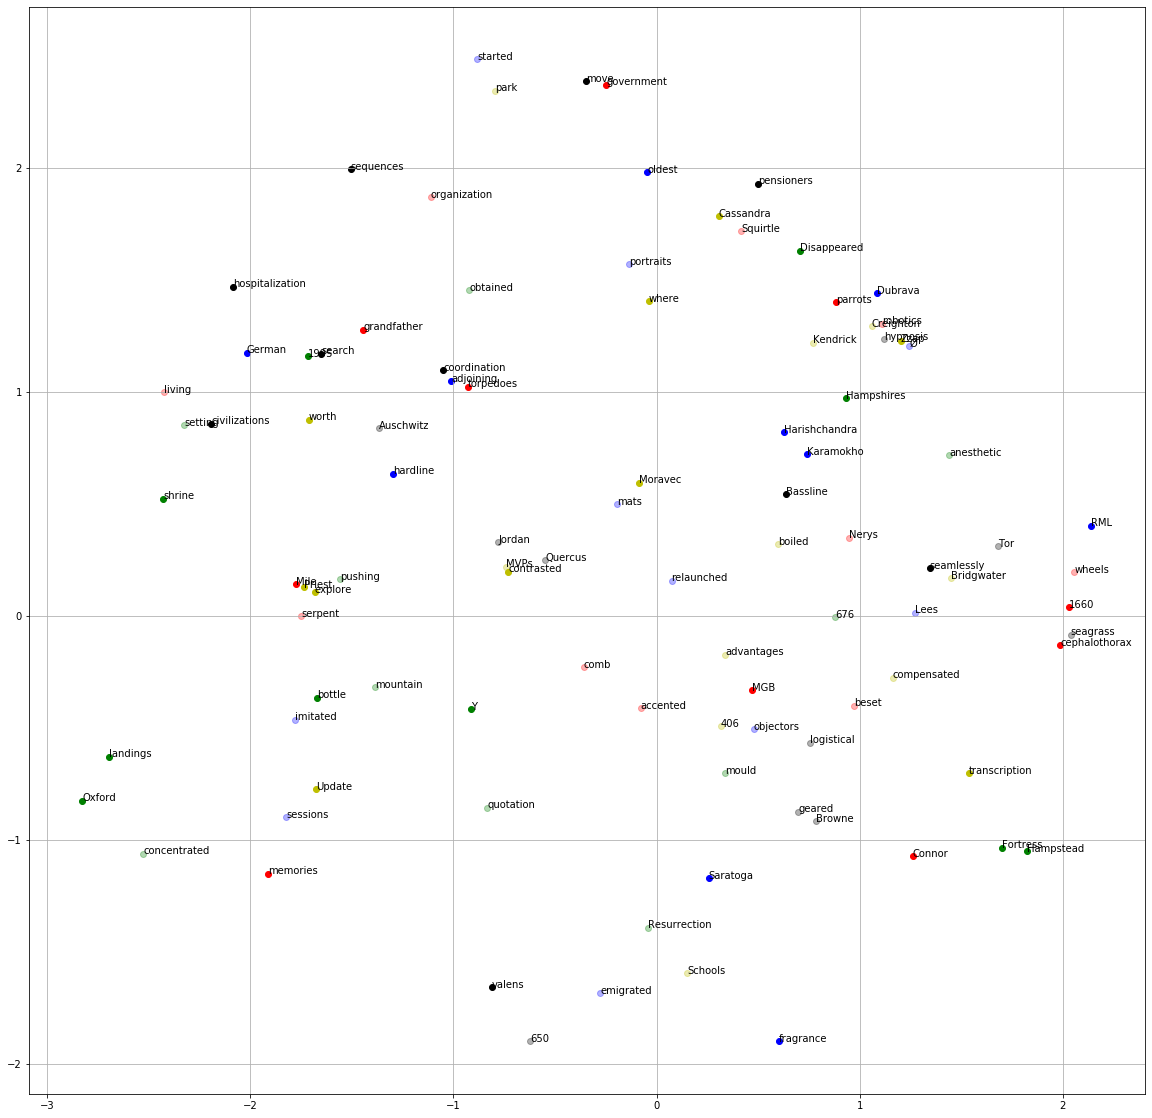

In [43]:
Vsize = len(wiki_dict)                             # e.g. len(dictionary)
d = model.lookup.weight.size(1)   # e.g. model.lookup.weight.size(1) 
weight_matrix = model.lookup.weight  # e.g. model.lookup.weight
words = []
word_ids = []
words_100 = [closest, furthest]
for i in words_100:
    for j in i:
        for k in range(10):
            words.append(i[j][k][0])
for i in words:
    idx = wiki_dict.get_id(i)
    word_ids.append(idx)
umap_plot(weight_matrix, word_ids, words)

#### II.2.3 Projection Layer

In [44]:
sample = ['government', 'where', '1995', 'search', 'German']
import operator

proj_closest = {}
proj_furthest = {}

for word in sample:
  sample_to_vec = model.projection.weight[wiki_dict.get_id(word)]
  proj_word_sim = {}
  for each in vocab:
    each_to_vec = model.projection.weight[wiki_dict.get_id(each)]
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    output = cos(each_to_vec.unsqueeze(0),sample_to_vec.unsqueeze(0)).item()
    proj_word_sim[each]=output
    
  sorted_dic = sorted(proj_word_sim.items(), key=operator.itemgetter(1))
  proj_closest[word] = sorted_dic[-10:]
  proj_furthest[word] = sorted_dic[:10]

In [47]:
for i in proj_closest:
    temp_output = []
    for j in range(10):
        temp_output.append(proj_closest[i][j][0])
    print("10 'closet' words of", i, "are", temp_output)
for i in proj_furthest:
    temp_output = []
    for j in range(10):
        temp_output.append(proj_furthest[i][j][0])
    print("10 'furthest' words of", i, "are", temp_output)

10 'closet' words of government are ['royal', 'building', 'administration', 'nuclear', 'army', 'authorities', 'church', 'military', 'fleet', 'government']
10 'closet' words of where are ['along', 'when', 'using', 'depending', 'via', 'but', 'regardless', 'highlighting', 'whose', 'where']
10 'closet' words of 1995 are ['2007', '2014', '1988', '1986', '1957', '1946', '2003', '1997', '1996', '1995']
10 'closet' words of search are ['benefit', 'blow', 'association', 'exchange', 'protest', 'gain', 'escape', 'shock', 'advance', 'search']
10 'closet' words of German are ['lumber', 'Japanese', 'Soviet', 'Italian', 'Allied', 'Chinese', 'Native', 'British', 'French', 'German']
10 'furthest' words of government are [',', 'that', ';', '(', 'the', 'a', 'in', ':', 'and', '–']
10 'furthest' words of where are ['<unk>', 'second', 'first', 'year', 'game', 'World', 'two', 'song', 'original', 'series']
10 'furthest' words of 1995 are [',', 'in', 'to', 'and', 'of', 'for', '@-@', 'was', '(', 'on']
10 'furth

D:\Software\Anaconda\lib\site-packages\numba\compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\..\..\Software\Anaconda\lib\site-packages\umap\nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


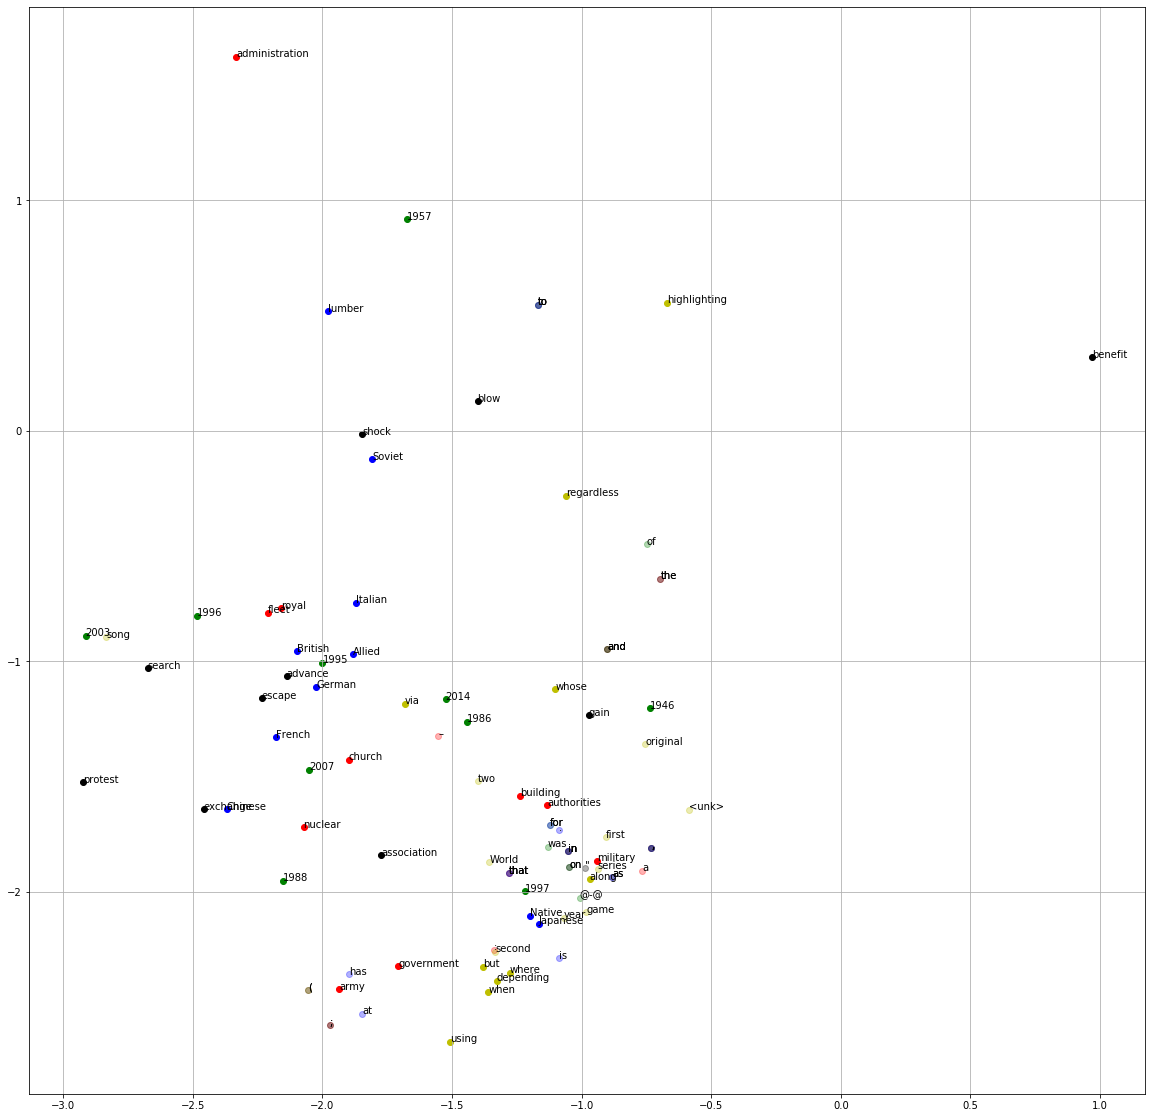

In [48]:
Vsize = len(wiki_dict)                             # e.g. len(dictionary)
d = model.lookup.weight.size(1)   # e.g. model.lookup.weight.size(1) 
weight_matrix = model.lookup.weight  # e.g. model.lookup.weight
words = []
word_ids = []
words_100 = [proj_closest, proj_furthest]
for i in words_100:
    for j in i:
        for k in range(10):
            words.append(i[j][k][0])
for i in words:
    idx = wiki_dict.get_id(i)
    word_ids.append(idx)
umap_plot(weight_matrix, word_ids, words)

Given our sample 'government', 'where', '1995', 'search' and 'German', which includes noun, number, verb and conjunction, the projection layer does a pretty good job determining the "closest" and furthest words regarding each. For example, as shown in the UMAP, where lighter color represents closer similarity and darker represents further, 'government' is found to be closer with 'church','authorities' and etc that both bear similar part-of-speech and semantic mearning with the target word, and further from words like 'where', 'from' that are more of conjunction words that normally cannot replace 'government'. Similar explanation can apply to other words in our sample.

Embedding layer visualization differs a a lot from projection layer, where the former is much scatter and makes less sense both for closest and furthest words list, and the latter is more aggregated and makes a lot more sense. 

### II.3 Scoring

In [28]:
def get_score(sequence, model_name):
  
  sequence = [0] + [wiki_dict.get_id(i) for i in sequence] + [1]
  sequence_tensored = torch.tensor([sequence], dtype=torch.long).to(current_device)
  logit = model_name(sequence_tensored)
  soft = nn.Softmax(dim=1)
  prob = soft(logit[0])
  logp = 0
  
  for i in range(len(prob) - 1):
    logp += np.log(float(prob[i][sequence[i+1]]))
    
  return logp

In [29]:
datasets, vocab = load_wikitext()
original_data = datasets.copy()

score_for_val = []
for i in original_data['valid']:
  score_for_val.append(get_score(i, model))

Vocab size: 33175


#### II.3.2 Highest and Lowest scoring sequences

In [30]:
print("Highest scoring sequences:")
arr = np.array(score_for_val)
for i in arr.argsort()[-10:][::-1]:
  print('Sequence {}: log probability = {:4f}, sentence: "{}"'.format(str(i), score_for_val[i], ' '.join(original_data['valid'][i])))

Highest scoring sequences:
Sequence 129: log probability = -14.635115, sentence: "= = Post @-@ war career = ="
Sequence 6750: log probability = -16.697021, sentence: "= = Early life and education = ="
Sequence 6464: log probability = -16.966561, sentence: "= = Post @-@ war period = ="
Sequence 3211: log probability = -25.315296, sentence: "unk> in the second half of the 7th century ."
Sequence 853: log probability = -25.460884, sentence: "= = Culture and the arts = ="
Sequence 3723: log probability = -25.716532, sentence: "= = = Scientology sources = = ="
Sequence 2020: log probability = -26.248292, sentence: "It premiered on the Fox network on October 30 , 1998 ."
Sequence 4284: log probability = -26.262680, sentence: "= = Return to New Zealand = ="
Sequence 4040: log probability = -26.332024, sentence: "= = Later life and death = ="
Sequence 4403: log probability = -26.481608, sentence: "= = = <unk> from the stage = = ="


In [31]:
print("Lowest scoring sequences:")
for i in arr.argsort()[:10]:
  print('Sequence {}: log probability = {:4f}, sentence: "{}"'.format(str(i), score_for_val[i], ' '.join(original_data['valid'][i])))

Lowest scoring sequences:
Sequence 3522: log probability = -545.382688, sentence: "To further justify its stance , the German government has also pointed to the long history of U.S. court cases involving Scientology , including the conviction of 11 top Scientologists in 1979 and 1980 for a conspiracy involving the infiltration of U.S. government agencies , <unk> and the theft of government documents , a 1994 U.S. Supreme Court finding that Scientology practices took place in a " <unk> environment " , and Scientology 's track record of pursuing its critics through malicious court cases and private investigators ."
Sequence 2723: log probability = -530.786788, sentence: "Two rival communist @-@ backed black nationalist groups initiated military campaigns to overthrow the government and introduce majority rule : the Chinese @-@ aligned Zimbabwe African National Union ( <unk> ) , mostly comprising <unk> , created the Zimbabwe African National Liberation Army ( ZANLA ) and adopted aspects o

#### II.3.3 Modified sequences

In [33]:
high = original_data['valid'][arr.argsort()[-9]]
print(' '.join(high))
get_score(high, model)

= = Later life and death = =


-26.069984908317167

In [34]:
for i in ['you', 'me', 'here', '=', 'education']:
  high[5] = i
  print(' '.join(high))
  print(get_score(high, model))  

= = Later life and you = =
-33.06517144210167
= = Later life and me = =
-31.182315950635545
= = Later life and here = =
-30.53862813294149
= = Later life and = = =
-24.580444921601497
= = Later life and education = =
-24.419107875001053


Sequence chosen: = = Later life and death = =
higher: = = Later life and education = =
Reason: The modified sequence has a higher score since "life and death" came from the sequence with the highest score among all the sequences, which is "= = Early life and education = =".

lower: = = Later life and you = =
Reason: "later life and you" gets a lower score because "life and you" is not a common expression compared to the original sequence, people rarely say things like that. 

### II.4 Sampling

In [35]:
soft = nn.Softmax(dim=1)

def sample_sequence(model_name,num = 1):
  ans = []
  for i in range(num):
    one_seq = []
    next_word = '<bos>'
    while next_word != '<eos>':
      one_seq.append(next_word)
      tensored_seq = torch.tensor([[wiki_dict.get_id(i) for i in one_seq]], dtype=torch.long).to(current_device)
      logit = model_name(tensored_seq)
      soft = nn.Softmax(dim=1)
      prob = soft(logit[0])[-1]
      next_word = wiki_dict.get_token(torch.multinomial(prob, 1))
    ans.append(one_seq[1:])

  return ans

In [36]:
sampled_1000 = sample_sequence(model, 1000)

#### II.4.3 Number of unique tokens and sequence length 

(1,000 samples vs. 1,000 randomly selected validation-set sequences)

In [37]:
import random
valid_1000 = random.sample(original_data['valid'],1000)
print('The average sequence length for sampled 1000 sentences is: {}.'.format(np.mean([len(i) for i in sampled_1000])))
print('The average sequence length for validation 1000 sentences is: {}.'.format(np.mean([len(i) for i in valid_1000])))
print('The number of unque tokens from sampled 1000 sentences is: {}.'.format(len(set([i for subsample in sampled_1000 for i in subsample]))))
print('The number of unque tokens from validation 1000 sentences is: {}.'.format(len(set([i for subsample in valid_1000 for i in subsample]))))

The average sequence length for sampled 1000 sentences is: 23.342.
The average sequence length for validation 1000 sentences is: 23.527.
The number of unque tokens from sampled 1000 sentences is: 5996.
The number of unque tokens from validation 1000 sentences is: 5070.


#### II.4.4 Example Samples

In [38]:
for i in random.sample(sampled_1000,3):
  print(' '.join(i[:-1]))
  print('----------------------')

The young Sampson operations were ready to capture the brunt of the roadway in Nevesinje
----------------------
She considered wins on the Southern Front for the rest of the 1910 season
----------------------
a sparse Catechism whose drinking ghost is possibly the right body , some years depicting his tomb
----------------------


- **Answer:** We can definately tell that these sentences are generated. They pretty much stayed on the same topic but the sentence in a whole doesn't make sense. The grammar for the whole sentence is often wrong, but within the range of 3 to 4 words the grammer is correct.